# Convex optimization: solving the LASSO problem

## Context:

Given $ x_1, \ldots, x_n \in \mathbf{R}^d $ data vectors and $ y_1, \ldots, y_n \in \mathbf{R} $ observations, we are searching for regression parameters $w \in \mathbf{R}^d$ which fit data inputs to observations y by minimizing their squared difference. In a high dimensional setting (when $n \ll d$) a $ l1 $ norm penalty is often used on the regression coefficients w in order to enforce sparsity of the solution (so that w will only have a few non-zeros entries). Such penalization has well known statistical properties, and makes the model both more interpretable, and faster at test time.

From an optimization point of view we want to solve the following problem called $\mathrm{LASSO}$ (which stands for Least Absolute Shrinkage Operator and Selection Operator):
$$
\operatorname{minimize} \quad \frac{1}{2}\|X w-y\|_2^2+\lambda\|w\|_1 \hspace*{1cm} (\mathrm{LASSO})
$$
in the variable $w \in \mathbf{R}^d$, where $X=\left(x_1^T, \ldots, x_n^T\right) \in \mathbf{R}^{n \times d}, y=\left(y_1, \ldots, y_n\right) \in \mathbf{R}^n$ and $\lambda>0$ is a regularization parameter.

## Deriving the dual of the problem

We show that the dual of the problem can be written:
$$
\begin{array}{ll}
\operatorname{minimize} & v^T Q v+p^T v \hspace*{1cm} (\mathrm{QP}) \\
\text { subject to } & A v \preceq b
\end{array}
$$
in variable $v \in \mathbf{R}^n$, where $Q \succeq 0$, with:
$$
\begin{array}{ll}
\mathbf{A} &= \begin{pmatrix} \mathbf{X}^\top \\ \mathbf{-X}^\top \end{pmatrix}  \\
\mathbf{Q} &=\frac{1}{2}I_{n} \\
p &= y \\
b &= \lambda\mathbf{1_{2d}} \\
\end{array}

$$
$Q \succeq 0$ hence the problem is convex. Moreover, since $\lambda>0$ and for the null vector $v=0$, $Av=0$. This way, the problem is stricly feasible and, thanks to Slater's constraint qualification, strong duality holds: we can solve $(\mathrm{LASSO})$ by solving $(\mathrm{QP})$.


In [11]:
# imports 
import numpy as np
from matplotlib import pyplot as plt
import cvxpy as cp

# from matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('svg')

# Solving $(\mathrm{QP})$ using Barrier method

In [2]:
class NotFeasible(Exception):
    pass

class QP:
    def __init__(self, Q, A, p, b, t):
        """
        Initialises QP problem parameters.
        """
        self._Q = Q
        self._A = A
        self._p = p
        self._b = b
        self._t = t
    
    def set_t(self, t):
        self._t = t

    def is_feasible(self, v):
        """
        Test whether point v is feasible.
        """
        return np.all(self._A @ v <= self._b)
    
    def is_strictly_feasible(self, v):
        """
        Test whether point v is stricly feasible.
        """
        return np.all(self._A @ v < self._b)

    def f0(self, v):
        """
        Returns objectif fonction evaluated at point v.
        """
        if not self.is_feasible(v):
            raise NotFeasible("The point is not feasible.")

        return (v @ self._Q) @ v + self._p @ v
    
    def f(self, v):
        """
        Return redifined objectif function evaluated at point v. 
        """
        if not self.is_strictly_feasible(v):
            raise NotFeasible("The point is not feasible.")
        
        return self._t * self.f0(v) - np.sum(np.log(- self._A @ v + self._b))
    
    def grad_f(self, v):
        """
        Gradient of the redifined objective function evaluated at point v.
        """
        return self._t * (2 * self._Q @ v + self._p) + np.sum(self._A / (- self._A @ v + self._b)[:, np.newaxis], axis=0)     
    
    def hessian_f(self, v):
        """
        Hessian of the redifined objective function evaluated at point v.
        """
        return 2 * self._t * self._Q + np.sum(self._A[:, :, np.newaxis] * self._A[:, np.newaxis, :] * (1/(- self._A @ v + self._b)**2)[:, np.newaxis, np.newaxis], axis=0)

## Solving the centering step

In [3]:
def backtracking(f, grad_f, v, search_dir, alpha=0.4, beta=0.7):
    step_size = 1

    while True:
        try:
            gap =  f(v + step_size * search_dir) - f(v) + alpha * step_size * grad_f(v) @ search_dir
            if gap < 0: 
                break
            else:
                step_size *= beta
        except NotFeasible: # point not feasible
            step_size *= beta

    return step_size

In [4]:
def centering_step(Q, p, A, b, t, v0, eps):
    # defining the QP problem
    qp = QP(Q, A, p, b, t)
    v = np.copy(v0)

    # keeping track of the progression
    v_seq, grad_seq = [], []

    while True:
        grad, hess = qp.grad_f(v), qp.hessian_f(v)
        grad_seq.append(grad)
        v_seq.append(np.copy(v))

        newton_step = np.linalg.solve(hess, - grad)
        newton_decrement = - grad @ newton_step

        if newton_decrement / 2 <= eps:
            break

        step_size = backtracking(qp.f, qp.grad_f, np.copy(v), newton_step)
        
        v += step_size * newton_step

    return v_seq, grad_seq

## Implementing barrier method

In [5]:
def barr_method(Q, p, A, b, v0, eps, t=0.5, mu=1.5, verbose=False):
    # defining the QP problem
    qp = QP(Q, A, p, b, t)
    v = np.copy(v0)

    # keeping track of progress
    v_seq = []
    n_inner = []
    prec_crit = []

    # making shure starting point is strictly feasible
    assert qp.is_strictly_feasible(v0), "Starting point is not strictly feasible"

    while True:
        prec_crit.append(A.shape[0] / t)
        v_seq.append(v)
        v_seq_inner, _ = centering_step(Q, p, A, b, t, v, eps)
        v = np.copy(v_seq_inner[-1])
        n_inner.append(len(v_seq_inner))

        if verbose:
            print(f"Iteration {len(n_inner)} after {n_inner[-1]} newton iterations")
        
        if A.shape[0] / t < eps:
            return v_seq, n_inner, prec_crit

        t *= mu
        qp.set_t(t)

# Running tests

In [6]:
# dimesions
d = 50
n = 100

# generate random data
np.random.seed(seed=10)
X = np.random.randn(n, d)
y = np.random.randn(n, )

# regularization parameter
lambd = 10

# QP optimization problem
Q = np.identity(n) * 0.5
p = y
A = np.vstack((X.T,-X.T))
b = lambd * np.ones((2 * d,))

# Barrier method parameters
eps = 1e-6
v0 = np.zeros(n)

In [7]:
v0 = np.zeros(n)
eps = 1e-3
v_seq, _, _ = barr_method(Q, p, A, b, v0, eps)
qp = QP(Q, A, p, b, 0.5)
print(f"optimal value: {qp.f0(v_seq[-1])}")

optimal value: -48.36035915447788


## Verifying results using cvxpy library

In [8]:
# Posing the dual problem
x = cp.Variable(n)
dual_prob = cp.Problem(
    cp.Minimize(
        cp.quad_form(x, Q) + p.T @ x
        ),
    [A @ x <= b]
)

# Solving the problem
dual_prob.solve()

# Printing the optimal solution
print(f"cvxpy optimal value: {dual_prob.value}")

cvxpy optimal value: -48.36048396249347


## Duality gap with respect to newton iterations

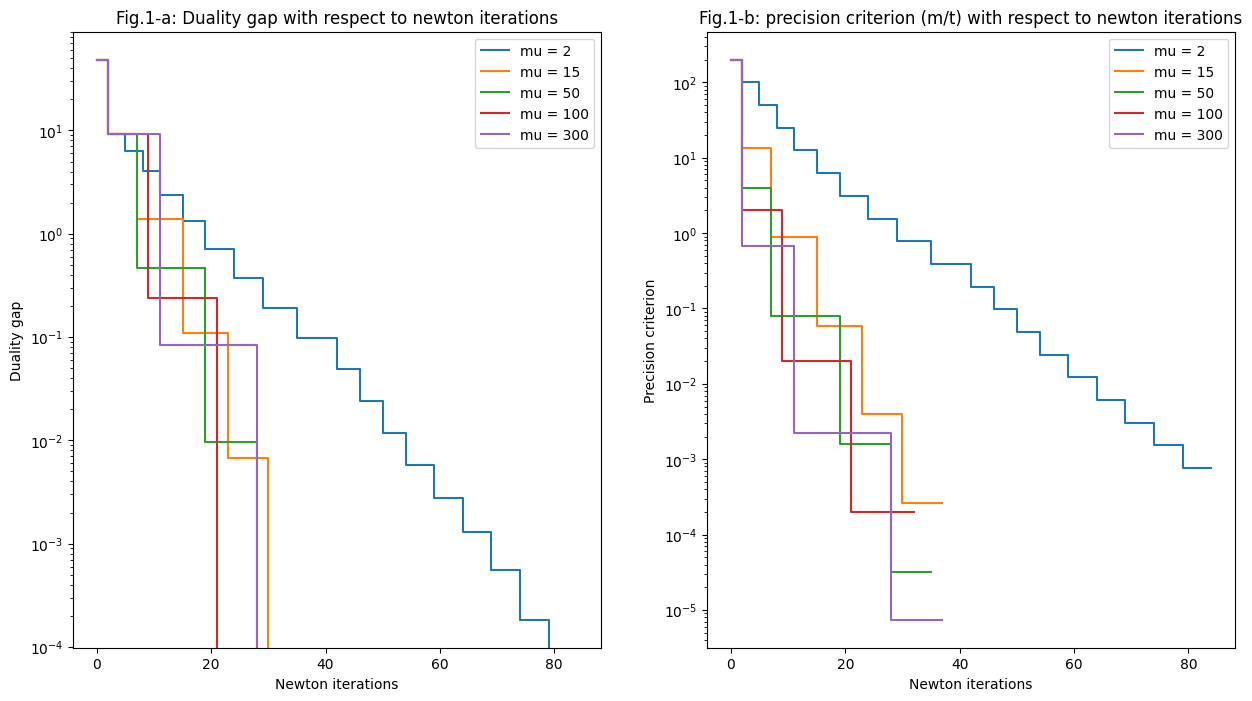

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

for mu in [2, 15, 50, 100, 300]:

    v_seq, n_inner, crit_prec = barr_method(Q, p, A, b, v0, eps, mu=mu)
    v_star = v_seq[-1]
    f_star = qp.f0(v_star)

    values_v = [qp.f0(v) - f_star for v, num in zip(v_seq, n_inner) for _ in range(num)]
    axs[0].step(range(len(values_v)), values_v, label='mu = '+str(mu))
    axs[0].semilogy()
    axs[0].legend()
    axs[0].set_title(f"Fig.1-a: Duality gap with respect to newton iterations")
    axs[0].set_xlabel('Newton iterations')
    axs[0].set_ylabel('Duality gap')


    values_crit_prec = [v for v, num in zip(crit_prec, n_inner) for _ in range(num)]
    axs[1].step(range(len(values_crit_prec)), values_crit_prec, label='mu = '+str(mu))
    axs[1].semilogy()
    axs[1].legend()
    axs[1].set_title(f"Fig.1-b: precision criterion (m/t) with respect to newton iterations")
    axs[1].set_xlabel('Newton iterations')
    axs[1].set_ylabel('Precision criterion')

## Total newton iterations with respect to mu

Text(0.5, 1.0, 'Fig.2: Total newton iterations with respect to mu')

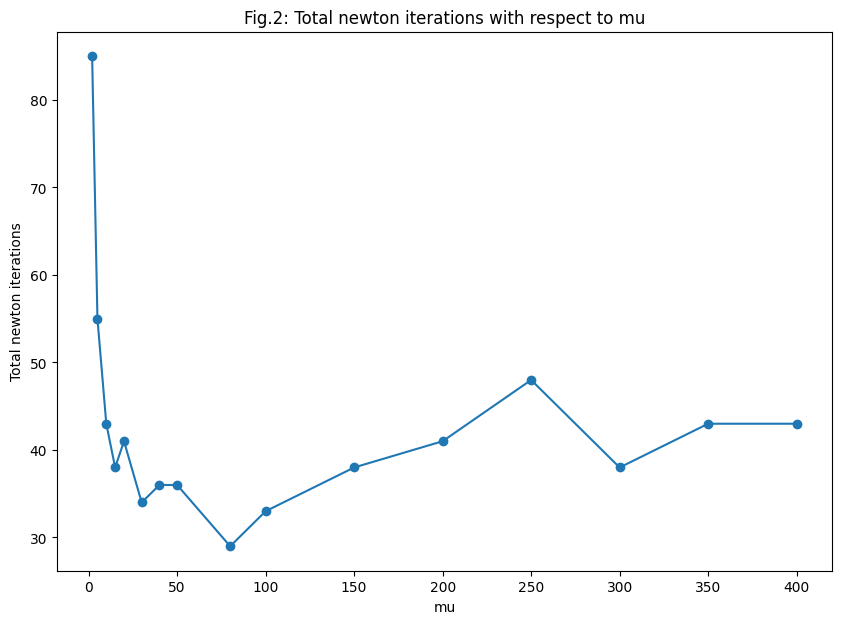

In [10]:
plt.figure(figsize=(10, 7))

mu_l = [2, 5, 10, 15, 20, 30, 40, 50, 80, 100, 150, 200, 250, 300, 350, 400]
n_inner_l = []

for mu in mu_l:
    _, n_inner_eps, _ = barr_method(Q, p, A, b, v0, eps, mu=mu)
    n_inner_l.append(sum(n_inner_eps))

plt.plot(mu_l, n_inner_l, 'o-')
plt.xlabel('mu')
plt.ylabel('Total newton iterations')
plt.title("Fig.2: Total newton iterations with respect to mu")

**Comment**

It seems that a wise choice is to set mu to a sufficiently large value, as we observe a significant drop in the total number of Newton steps (Fig. 2) from mu=2 to mu=20. Indeed, we can distinguish two linear tendencies in Fig. 1, where, from mu=15, we observe fewer steps with a more substantial reduction in the dual gap.

After that, the difference in the number of inner Newton iterations becomes less significant, even though it appears to show an increasing tendency. Here, mu=100 appears to be the most appropriate choice among the values tested